In [ ]:
####U_NET WITH DATA AND IMAGES
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import glob
import sys
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, concatenate, Dense, Flatten, Activation, Conv2DTranspose, BatchNormalization
from keras.models import Sequential, Model
from keras.applications import DenseNet201
from keras.optimizers import Adam,SGD
from keras.metrics import MeanIoU, Precision, Recall,Accuracy,BinaryAccuracy
from keras.losses import  BinaryFocalCrossentropy, BinaryCrossentropy
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import random
print(tf.__version__)
print(sys.version)






# Read Filepaths

In [ ]:
filepath_4 = 'C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\preprocessed\\train\\image\\'
filepath_5 = 'C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\preprocessed\\train\\label\\'
filepath_6 = 'C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\preprocessed\\val\\image\\'
filepath_7 = 'C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\preprocessed\\val\\label\\'

# Numerical Data feature vector handling For training and Validation set

the numerical data is of form
T
he 12 columns of data are (Q = Quality, hdop = Horizontal Degree of Precision, ns = nanoseconds, IMU = Inertial Measurement Unit). 

Note: The table below is an example of an image.

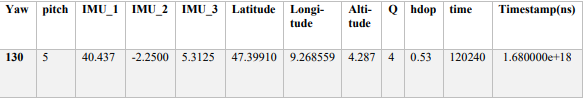


In [ ]:
filters = 64


def data_frame_num():
    #data_frame = pd.read_csv('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\Attachments\\main_all_data_folder_1.csv', header = None)
    data_frame = pd.read_csv('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\Attachments\\concatenated_folder_1_folder_2.csv', header = None)
    data_frame = data_frame.iloc[:,2:]
    print(data_frame.shape)
    return data_frame
data_frame = data_frame_num()
print(data_frame)
print(np.shape(data_frame)) 

input_x = tf.convert_to_tensor(data_frame) 
input_x.shape 
scaling = MinMaxScaler()

input_x_normal = pd.DataFrame(scaling.fit_transform(data_frame), columns = data_frame.columns)
print((input_x_normal))
# print((input_x_normal))


input_x = tf.convert_to_tensor(input_x_normal.values.reshape((-1,1,1,12))) 
print(input_x.shape[0])
print(type(input_x))

input_x = np.tile(input_x, [1,16,16,1]).astype('float32')


###2nd for val_numerical_data read from another csv made
def data_frame_num_val():  
    data_frame_val = pd.read_csv('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\Attachments\\main_all_data_folder_1_validation.csv', header = None)
    data_frame_val = data_frame_val.iloc[:,2:]
    return data_frame_val
    
data_frame_val = data_frame_num_val()     ##### (26,5)  (rows,columns)
print(np.shape(data_frame_val)) 

input_x_val = tf.convert_to_tensor(data_frame_val) 
input_x_val.shape 

scaling = MinMaxScaler()

input_x_normal_val = pd.DataFrame(scaling.fit_transform(data_frame_val), columns = data_frame_val.columns)
print((input_x_normal_val))
# print((input_x_normal))

input_x_val_num = tf.convert_to_tensor(input_x_normal_val.values.reshape((-1,1,1,12))) 
print(input_x_val_num.shape[0])

input_x_val_num = np.tile(input_x_val_num, [1,16,16,1]).astype('float32')
print(input_x_val_num.shape, 'Validation values reshaped to pixel wise which is at the bottom neck layer')

# Custom Data Generation from Folders with Image augmentation

In [ ]:
tf.random.set_seed(42)

train_num_1 = tf.data.Dataset.from_tensor_slices(input_x).batch(2).repeat(20)
print(np.shape(train_num_1))
print(len(train_num_1))
#print(train_num)

train_num_1_ = next(iter(train_num_1))
input_num_2 = train_num_1_.numpy().astype('float32') 
print(input_num_2.shape)

val_num_1 = tf.data.Dataset.from_tensor_slices(input_x_val_num).batch(2).repeat(20)
print(np.shape(val_num_1))
print(type(val_num_1))
train_val_1_ = next(iter(val_num_1))
input_val_2 = train_val_1_.numpy().astype('float32')
print(type(input_val_2))
print(input_val_2.shape)

data_generation = ImageDataGenerator(rescale= 1/255.,width_shift_range = 0.1, 
                                     height_shift_range = 0.1,
                                     shear_range =0.2, zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode =  'nearest')
data_generation_1 = ImageDataGenerator(rescale= 1/255.,width_shift_range = 0.1, 
                                     height_shift_range = 0.1,
                                     shear_range =0.2, zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode =  'nearest')    #preprocessing_function = lambda s: np.where(s>0,1,0).astype(s.dtype)
   
training_image = data_generation.flow_from_directory('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\Attachments\\preprocessed\\train\\image\\',
                                                        target_size =(256,256),
                                                         batch_size =1,
                                                         class_mode = None,
                                                         color_mode = 'rgb',
                                                         seed = 42)
training_mask = data_generation_1.flow_from_directory('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\Attachments\\preprocessed\\train\\label\\', 
                                                         
                                                        target_size =(256,256),
                                                         batch_size =1,
                                                         class_mode = None,
                                                         color_mode = 'grayscale',
                                                         seed = 42) 

validation_image = data_generation.flow_from_directory('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\Attachments\\preprocessed\\val\\image\\',
                                                         
                                                        target_size =(256,256),
                                                         batch_size = 1,class_mode = None,
                                                         color_mode = 'rgb',
                                                         seed = 42)        
    #seed of both the directories should be same.

validation_mask = data_generation_1.flow_from_directory('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\Attachments\\preprocessed\\val\\label\\', 
                                                        target_size =(256,256),
                                                         batch_size =1,
                                                         class_mode = None,
                                                         color_mode = 'grayscale',
                                                         seed = 42)

# Image data handling

In [ ]:
x = []
for z in range(287):
    train_im = next(iter(training_image)).astype('float32')
    x.append(train_im[0])
print(train_im.shape)
print(np.shape(x))

x_mask = []
for f in range(287):
    train_mas = next(iter(training_mask)).astype('float32')
    x_mask.append(train_mas[0])
print(train_mas.shape)
print(np.shape(x_mask))

y = []
for d in range(21):
    val_im = next(iter(validation_image)).astype('float32')
    y.append(val_im[0])
print(val_im.shape)
print(np.shape(y))

y_mask = []
for r in range(21):
    val_mas = next(iter(validation_mask)).astype('float32')
    y_mask.append(val_mas[0])

print(val_mas.shape)
print(np.shape(y_mask))


# Setting the data for inputs to the model

2.12.0
3.11.1 (tags/v3.11.1:a7a450f, Dec  6 2022, 19:58:39) [MSC v.1934 64 bit (AMD64)]
[]
[]
[]
[]
[]
Found 287 images belonging to 1 classes.
Found 287 images belonging to 1 classes.
Found 21 images belonging to 1 classes.
Found 21 images belonging to 1 classes.
287
287
21
21
(1, 256, 256, 3)
(287, 256, 256, 3)
(1, 256, 256, 1)
(287, 256, 256, 1)
(1, 256, 256, 3)
(21, 256, 256, 3)
(1, 256, 256, 1)
(21, 256, 256, 1)
<class 'tensorflow.python.data.ops.repeat_op._RepeatDataset'>
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)   

c:\Users\Shah\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 pool2_conv (Conv2D)            (None, 64, 64, 128)  32768       ['pool2_relu[0][0]']             
                                                                                                  
 pool2_pool (AveragePooling2D)  (None, 32, 32, 128)  0           ['pool2_conv[0][0]']             
                                                                                                  
 conv3_block1_0_bn (BatchNormal  (None, 32, 32, 128)  512        ['pool2_pool[0][0]']             
 ization)                                                                                         
                                                                                                  
 conv3_block1_0_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block1_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

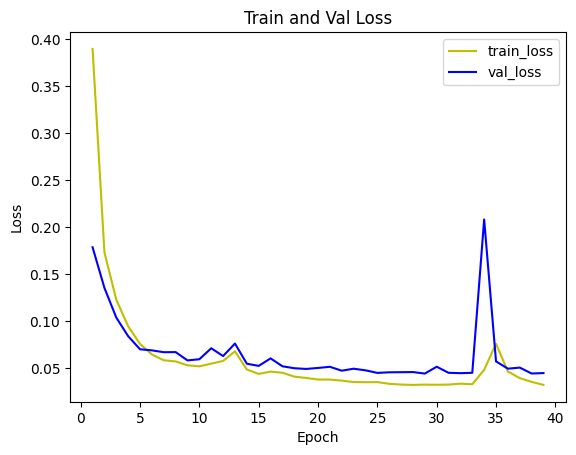

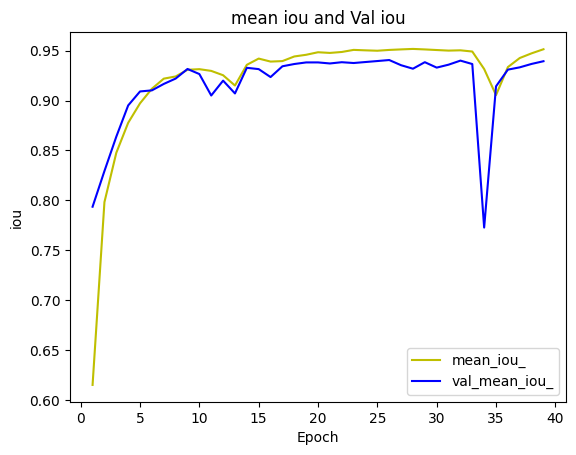

In [ ]:
tf.random.set_seed(42)

####zipping the files for training and validation for model.fit
x = np.array(x)
x_train = tf.data.Dataset.from_tensor_slices((x,input_x)).batch(3).repeat()
#print(len(x_train))
print(type(x_train))
x_mask = np.array(x_mask)
x_mask_train = tf.data.Dataset.from_tensor_slices(x_mask).batch(3).repeat()
#print(len(x_mask_train))
data = tf.data.Dataset.zip((x_train,x_mask_train))
print(data.element_spec)


y = np.array(y)
y_val = tf.data.Dataset.from_tensor_slices((y, input_x_val_num)).batch(3).repeat()
#print(len(y_val))
y_mask = np.array(y_mask)
y_mask_val = tf.data.Dataset.from_tensor_slices(y_mask).batch(3).repeat()
#print(len(y_mask_val))
data_2 = tf.data.Dataset.zip((y_val,y_mask_val))
print(data_2.element_spec)


# Figure Plot Visualization

In [ ]:
####Figure Plotting
train_data = tf.data.Dataset.from_tensor_slices((x,x_mask)).take(4)
# figure,ax = plt.subplots(2,2,figsize = (10,10))
for image_train,image_mask in (train_data):
    figure = plt.figure()
    im = image_train
    ax = figure.add_subplot(1,2,1)
    ax.imshow(im, cmap = 'gray')
    plt.title('train_set_image')
    mas = image_mask
    ax1 = figure.add_subplot(1,2,2)
    ax1.imshow(mas, cmap = 'gray')
    plt.title('train_set_mask')

validation = tf.data.Dataset.from_tensor_slices((y,y_mask)).take(4)
for y,y_mask in (validation):
    figure = plt.figure()
    im = y
    ax = figure.add_subplot(1,2,1)
    ax.imshow(im, cmap = 'gray')
    plt.title('val_set_image')
    mas = y_mask
    ax1 = figure.add_subplot(1,2,2)
    ax1.imshow(mas, cmap = 'gray')
    plt.title('val_set_mask')

# U_Net model trained by fusing Numerical and Image feature vectors

In [ ]:
def convolutional(input_shape, filters, pooling = True):
    
    convolutional_block = Conv2D(filters = filters, kernel_size = 3, 
                                 activation = 'relu',
                                 strides = (1,1), 
                                 padding  = 'same', 
                                 kernel_initializer  = 'he_normal' )(input_shape)    #Functional API'S
    
    
    convolutional_block = Conv2D(filters = filters ,kernel_size = 3, 
                                 activation = 'relu',
                                 strides = (1,1), 
                                 padding  = 'same', 
                                 kernel_initializer  = 'he_normal' )(convolutional_block)   #check which more kernel initializer we can add together using list
    if pooling == True:
        
        connect = MaxPool2D((2,2))(convolutional_block)
       
        return connect
    
    else:
        return convolutional_block

def expansion(input_1,input_2,filters): #
    
    conv_up_sample = Conv2DTranspose(filters = filters, kernel_size = (3,3), strides = (2,2),padding = 'same')(input_1)
    #print(conv_up_sample)
    addition = concatenate([conv_up_sample, input_2], axis = -1)
    convolve = Conv2D(filters = filters, kernel_size = 3, 
                                 activation = 'relu',
                                 strides = (1,1), 
                                 padding  = 'same', 
                                 kernel_initializer  = 'he_normal')(addition)
     
    convolve = Conv2D(filters = filters, kernel_size = 3, 
                                 activation = 'relu',
                                 strides = (1,1), 
                                 padding  = 'same', 
                                 kernel_initializer  = 'he_normal')(convolve) 
    return convolve 

# #block_of_expansion = expansion(input_1,input_2,filters)
input_num_1 = (16,16,12)
def U_Net_Segmentation_Model(input_shape,input_num_1):
    
    inputs = Input(input_shape)
    input_num = Input(input_num_1)
    
    contract_1 = convolutional(inputs,filters)
    print(contract_1)
    contract_2=  convolutional(contract_1, filters * 2, pooling = True)
    print(contract_2)
    contract_3 = convolutional(contract_2, filters * 4,pooling =  True)
    print(contract_3)
    contract_4 = convolutional(contract_3, filters * 8, pooling = True)
    print(contract_4)
    
    
    bottle_layer_5 = convolutional(contract_4, filters * 16, pooling = False)   #(32,32,512)  + (26,5)
    print(bottle_layer_5, 'bottle_neck_layer')
    
    
    features = Flatten()(bottle_layer_5)
    print(features)
    
    print(features.shape, 'features_shape')
    
    input_expansion_2 = Flatten()(tf.reshape(input_num,[-1,16,16,12]))      #check should we reshape into batch_size 32*32*5 this is due to we are adding this in thebottle neck layer at the last axis or batch_size*1*5
    print(input_expansion_2.shape, ' Input_expansion_2')
    
    feature = concatenate([features,input_expansion_2], axis = -1)
    print(feature, 'features_bottle_layer_z')
    
    feature_1 = tf.reshape(feature, [-1,16,16,1036]) 
    print(feature_1)
    
    
    expansion_1 = expansion(feature_1,contract_3, 1036//2)  #bottle_layer_5
    print(expansion_1)
    expansion_2=  expansion(expansion_1,contract_2, 1036//4)
    print(expansion_2)
    expansion_3 = expansion(expansion_2,contract_1, 1036//8)
    print(expansion_3)
    expansion_4 = expansion(expansion_3,inputs, 1036//16)
    print(expansion_4)
   
    
    Conv_1 = Conv2D(filters = 1036//32, kernel_size = 3, 
                                 activation = 'relu',
                                 padding  = 'same', 
                                 kernel_initializer  = 'he_normal' )(expansion_4) 
    
      
     
   
    u_net_output = Conv2D(1, kernel_size =1,activation = 'sigmoid', padding  = 'same')(Conv_1) # here 1 defines the number of classes classes = 2 segmented glass or not......
    
    model = Model(inputs =[inputs,input_num], outputs = u_net_output)   #here may be we have to write input_1 also  
    print(model.input_shape)
    
    return model


input_shape = (256,256,3)   ###this changes according to the format of image filter 1,3,4
np.shape(input_shape)
print(input_shape) 




# Training and plotting the metrics

In [ ]:
##Introduced by Sudre et al. in Generalised Dice overlap as a deep learning loss function for highly unbalanced segmentations  
def dice_loss(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    dice_loss = 1.0 - dice_coefficient
    return dice_loss


model= U_Net_Segmentation_Model(input_shape,input_num_1)
model.compile(optimizer = Adam(lr = 0.00001), 
                               loss =dice_loss, 
                               metrics=[BinaryAccuracy(threshold=0.5),Precision(),Recall(),MeanIoU(num_classes = 2)])

model.summary()

checkpoint = ModelCheckpoint('C:\\Users\\Shah\\OneDrive - IWT Wirtschaft und Technik GmbH\\only_u_net_model_images_and_data_lr_0.0001_1036.h5', verbose = 1, save_best_only = True)
callbacks = [EarlyStopping(patience = 10, monitor = 'val_loss'), checkpoint]
print(len(training_image))
print(len(validation_image))

history_unet = model.fit(data,steps_per_epoch =287//3, verbose = 1, callbacks = callbacks , validation_data =data_2, validation_steps = 21//7, epochs = 50)


## see here how to add the input numerical data for fitiing
losses = history_unet.history['loss']
validation_losses = history_unet.history['val_loss']
#epoch = (1, len(losses))
epochs = list(range(1, len(losses)+1))
plt.plot(epochs, losses,'y', label = 'train_loss')
plt.plot(epochs, validation_losses, 'b', label = 'val_loss')
plt.title('Train and Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

mean_iou = history_unet.history['mean_io_u']
val_mean_iou = history_unet.history['val_mean_io_u']
epochs = list(range(1, len(losses)+1))
plt.plot(epochs, mean_iou,'y', label = 'mean_iou_')
plt.plot(epochs, val_mean_iou, 'b', label = 'val_mean_iou_')
plt.title('mean iou and Val iou')
plt.xlabel('Epoch')
plt.ylabel('iou')
plt.legend()
plt.show()
